In [1]:
# http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html

In [1]:
import statsmodels.api as sm
from sklearn import linear_model
import numpy as np
import pandas as pd
from patsy import dmatrices
from sklearn import metrics
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import matplotlib as mpl
print("python " + sys.version)
print("")
print("pandas " + str(pd.__version__))
print("numpy " + np.__version__)

python 2.7.12 |Anaconda 2.5.0 (64-bit)| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]

pandas 0.18.1
numpy 1.11.2


In [3]:
df = sm.datasets.fair.load_pandas().data

In [4]:
df.head(4)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273


##### data exploration

In [5]:
# some summary statistics.
#misleading - [ explained towards the end. bottom line - exercise caution while interpreting summary stats ]

In [6]:
df.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991


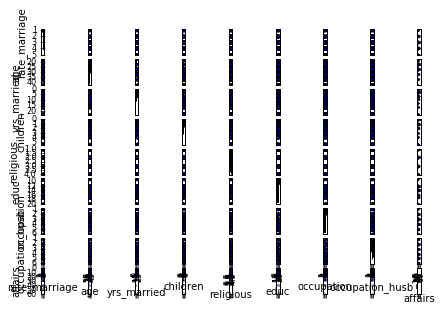

In [7]:
#need to run this to see the figures. 
#%matplotlib inline

import matplotlib.pyplot as plt

axes = pd.tools.plotting.scatter_matrix(df, alpha=0.2)
plt.tight_layout()
plt.savefig('scatter_matrix.png')
#plt.show()

In [8]:
df['affair_bool'] = (df.affairs > 0).astype(int)

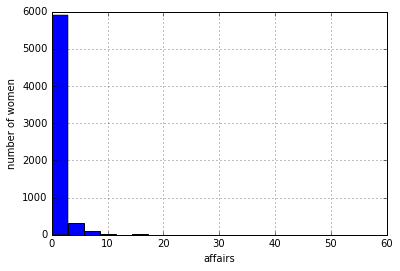

In [9]:
df['affairs'].hist(bins=20)
xlabel('affairs')
ylabel('number of women')

In [10]:
#Exploring affairs vs marraige ratings : 

In [11]:
rating_vs_target = pd.crosstab(df['rate_marriage'], df['affair_bool'])
rating_vs_target

affair_bool,0,1
rate_marriage,,
1.0,25,74
2.0,127,221
3.0,446,547
4.0,1518,724
5.0,2197,487


In [12]:
total_ratings = rating_vs_target.apply(sum)
total_ratings

affair_bool
0    4313
1    2053
dtype: int64

In [13]:
rating_vs_target /= total_ratings
rating_vs_target

affair_bool,0,1
rate_marriage,,
1.0,0.005796,0.036045
2.0,0.029446,0.107647
3.0,0.103408,0.266439
4.0,0.351959,0.352655
5.0,0.509390,0.237214


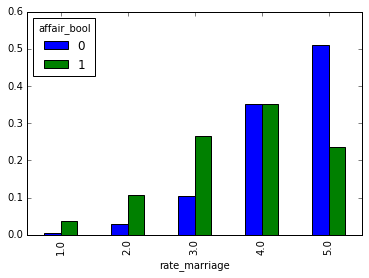

In [14]:
rating_vs_target.plot(kind='bar')

##### Conclusion - Women who rate their marriages higher have lesser number of affairs. Let use a model to verify our claim.

In [15]:
#splitting the model into train and test sets

In [16]:
#set the random state to get the same split each time
from sklearn.cross_validation import train_test_split
x_train, x_test = train_test_split(df, test_size=0.2, random_state=42)

/home/akshata/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
train_y = x_train["affair_bool"]

In [18]:
test_y = x_test["affair_bool"]

In [19]:
x_train = x_train.drop("affairs", axis = 1, inplace = False)
x_train = x_train.drop("affair_bool", axis = 1, inplace = False)

In [20]:
x_test = x_test.drop("affairs", axis = 1, inplace = False)
x_test = x_test.drop("affair_bool", axis = 1, inplace = False)

In [21]:
#fitting the model

In [22]:
logit = linear_model.LogisticRegression()
logit.fit(x_train,train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
#making predictions. By default, 0.5 is chosen as the threshold

In [24]:
predicted = logit.predict(x_test)

In [25]:
#calculating accuracy

In [26]:
np.mean((predicted - test_y)**2)

0.28100470957613816

In [27]:
#coefficients

In [28]:
logit.coef_

array([[-0.68386705, -0.04990899,  0.10236987, -0.01012432, -0.35709835,
        -0.02578675,  0.1606459 ,  0.01511249]])

In [29]:
logit.intercept_

array([ 3.12439693])

In [30]:
weights = pd.Series(logit.coef_[0],
                 index= x_train.columns.values)
weights.sort_values()

rate_marriage     -0.683867
religious         -0.357098
age               -0.049909
educ              -0.025787
children          -0.010124
occupation_husb    0.015112
yrs_married        0.102370
occupation         0.160646
dtype: float64

##### Conclusions - We observed from the bar graph that a higher marriage rating means a lower chance of having an affair. The negative coefficient value of rate_marriage variable - -0.683867 tells us exactly that. But are we on the right track?

In [31]:
# We observe that the occupation husb and occupation columns are categorical columns. We need to make them categorical so we will use design matrices.
# The C(occupation_husb) and C(occupation) is doing just that

In [32]:
y, X = dmatrices('affair_bool ~ rate_marriage + age + educ + children + C(occupation_husb) + C(occupation) + yrs_married', df, return_type = 'dataframe')

In [33]:
logit_categorical = linear_model.LogisticRegression(fit_intercept = False, C = 1e9)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [35]:
logit_categorical.fit(X_train,y_train)

/home/akshata/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [36]:
logit_categorical.coef_

array([[  1.93336242e+00,   6.01480074e-02,   1.71618953e-01,
          4.12500848e-02,   1.17405251e-02,  -1.66178660e-04,
          8.06450629e-01,   1.07840612e+00,   8.16342755e-01,
          1.44762838e+00,   1.61121363e+00,  -7.31529603e-01,
         -6.04893098e-02,   3.26316601e-03,  -3.87700602e-02,
          1.06596498e-01]])

In [37]:
weights_categories = pd.Series(logit_categorical.coef_[0],
                 index= X.columns.values)
weights_categories.sort_values()

rate_marriage               -0.731530
age                         -0.060489
children                    -0.038770
C(occupation_husb)[T.6.0]   -0.000166
educ                         0.003263
C(occupation_husb)[T.5.0]    0.011741
C(occupation_husb)[T.4.0]    0.041250
C(occupation_husb)[T.2.0]    0.060148
yrs_married                  0.106596
C(occupation_husb)[T.3.0]    0.171619
C(occupation)[T.2.0]         0.806451
C(occupation)[T.4.0]         0.816343
C(occupation)[T.3.0]         1.078406
C(occupation)[T.5.0]         1.447628
C(occupation)[T.6.0]         1.611214
Intercept                    1.933362
dtype: float64

In [38]:
# This makes more sense. Let's calculate the accuracy insample 

In [39]:
logit_categorical.score(X_train, y_train)

0.71970377019748655

In [40]:
# Let's now check the out of sample test accuracy 

In [41]:
predicted_logit_categorical = logit_categorical.predict(X_test)

In [42]:
metrics.accuracy_score(y_test, predicted_logit_categorical)

0.73403141361256541

In [43]:
#getting the predicted probabilities.
predicted_prob = logit_categorical.predict_proba(X_test)

##### How do we choose the cut off threshold? 
##### 1. Depends on the business problem
##### 2. Related to 1 - How much error are we willing to make by predicting either class


In [44]:
predicted_class_1 = [item[1] for item in predicted_prob]


In [45]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_class_1)
roc_auc = metrics.auc(fpr,tpr)

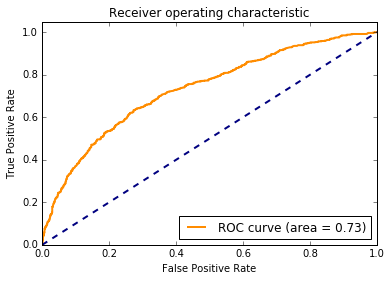

In [46]:
#adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('roc.png')
plt.show()


### REGULARIZATION 

### Switch to Emma

What if the effect of husband's occupation depends on the wife's occupation, or the effect of number of children depends on years married? 

We can add features to include interaction terms. 

In [47]:
print X_train.shape 
print X_test.shape 

(4456, 16)
(1910, 16)


We can see the current dataset has 16 features. With PolynomialFeatures, we can create all second order features in one command. 

In [48]:
# we want to drop the intercept first
# Note we want to standardize the data first

In [49]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train_2 = poly.fit_transform(X_train)
X_test_2 = poly.fit_transform(X_test)

In [50]:
print X_train_2.shape 
print X_test_2.shape 

(4456, 153)
(1910, 153)


There is 1 feature for the intercept, 16 original features, 16 second order features for the original 16 features, and 16-choose-2(120) second order interacting features. The total number of features is 153 as expected.

The outputs of PolynomialFeatures are numpy arrays. Let's add the column names back and make some dataframes. 

In [51]:
target_feature_names = poly.get_feature_names(X_train.columns.values)
X_train_2_df = pd.DataFrame(X_train_2, columns = target_feature_names)
X_test_2_df = pd.DataFrame(X_test_2, columns = target_feature_names)

In [52]:
print target_feature_names[::3]

['1', 'C(occupation_husb)[T.3.0]', 'C(occupation_husb)[T.6.0]', 'C(occupation)[T.4.0]', 'rate_marriage', 'children', 'Intercept C(occupation_husb)[T.2.0]', 'Intercept C(occupation_husb)[T.5.0]', 'Intercept C(occupation)[T.3.0]', 'Intercept C(occupation)[T.6.0]', 'Intercept educ', 'C(occupation_husb)[T.2.0]^2', 'C(occupation_husb)[T.2.0] C(occupation_husb)[T.5.0]', 'C(occupation_husb)[T.2.0] C(occupation)[T.3.0]', 'C(occupation_husb)[T.2.0] C(occupation)[T.6.0]', 'C(occupation_husb)[T.2.0] educ', 'C(occupation_husb)[T.3.0]^2', 'C(occupation_husb)[T.3.0] C(occupation_husb)[T.6.0]', 'C(occupation_husb)[T.3.0] C(occupation)[T.4.0]', 'C(occupation_husb)[T.3.0] rate_marriage', 'C(occupation_husb)[T.3.0] children', 'C(occupation_husb)[T.4.0] C(occupation_husb)[T.5.0]', 'C(occupation_husb)[T.4.0] C(occupation)[T.3.0]', 'C(occupation_husb)[T.4.0] C(occupation)[T.6.0]', 'C(occupation_husb)[T.4.0] educ', 'C(occupation_husb)[T.5.0]^2', 'C(occupation_husb)[T.5.0] C(occupation)[T.3.0]', 'C(occupatio

In [53]:
X_train_2_df.head()

,1,Intercept,C(occupation_husb)[T.2.0],C(occupation_husb)[T.3.0],C(occupation_husb)[T.4.0],C(occupation_husb)[T.5.0],C(occupation_husb)[T.6.0],C(occupation)[T.2.0],C(occupation)[T.3.0],C(occupation)[T.4.0],...,age^2,age educ,age children,age yrs_married,educ^2,educ children,educ yrs_married,children^2,children yrs_married,yrs_married^2
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,729.0,432.0,27.0,162.0,256.0,16.0,96.0,1.0,6.0,36.00
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1764.0,588.0,168.0,966.0,196.0,56.0,322.0,16.0,92.0,529.00
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1369.0,518.0,148.0,851.0,196.0,56.0,322.0,16.0,92.0,529.00
3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,484.0,264.0,0.0,55.0,144.0,0.0,30.0,0.0,0.0,6.25
4,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,484.0,308.0,0.0,55.0,196.0,0.0,35.0,0.0,0.0,6.25


Now let's fit a new logistic regression with our freshly made features :) For easy comparison, we use the same parameters as used in the previous model.

In [54]:
model = linear_model.LogisticRegression(fit_intercept = False, penalty = 'l2', C= 1e9)
model.fit(X_train_2_df,y_train)

print 'train_score = ', model.score(X_train_2_df, y_train)
    
predicted = model.predict(X_test_2_df)
print 'test_score = ', metrics.accuracy_score(y_test, predicted)

train_score =  0.731597845601
test_score =  0.717277486911


What are the most important features this time?

In [55]:
weights_categories = pd.Series(model.coef_[0],
                 index= X_train_2_df.columns.values)
weights_categories.sort_values()[:10]

Intercept rate_marriage                          -0.417261
rate_marriage                                    -0.417261
C(occupation_husb)[T.4.0] C(occupation)[T.6.0]   -0.361173
C(occupation)[T.3.0]^2                           -0.295905
Intercept C(occupation)[T.3.0]                   -0.295905
C(occupation)[T.3.0]                             -0.295905
C(occupation_husb)[T.2.0] yrs_married            -0.245166
C(occupation_husb)[T.6.0] yrs_married            -0.238798
C(occupation_husb)[T.3.0] C(occupation)[T.5.0]   -0.217057
C(occupation_husb)[T.3.0] C(occupation)[T.4.0]   -0.209103
dtype: float64

The testing error is a bit larger than the training error. We may be overfitting the dataset. Why don't we try some regularization? 

In [56]:
def fit_order2(pen,reg):
    model = linear_model.LogisticRegression(fit_intercept = False, penalty = pen, C= reg)
    model.fit(X_train_2_df,y_train)
    
    #print model.coef_
    train_score = model.score(X_train_2_df, y_train)
    
    predicted = model.predict(X_test_2_df)
    test_score = metrics.accuracy_score(y_test, predicted)
    
    return train_score, test_score, model.coef_[0]

Let's train a suite of models with various regularization strength.

In [57]:

penalties = [1e9, 1e6, 1e4, 1e2, 10, 1, 1e-1, 1e-2, 1e-3, 1e-4]
types = ['l1', 'l2']

train_score = np.zeros([len(types),len(penalties)])
test_score = np.zeros([len(types),len(penalties)])
coeff = np.zeros([len(types),len(penalties),X_train_2_df.shape[1]])

In [58]:
for i in range(len(types)):
    for j in range(len(penalties)):
        (train_score[i,j], test_score[i,j], coeff[i,j,:]) = fit_order2(types[i], penalties[j])

In [59]:
print train_score[0,:]
print test_score[0,:]


[ 0.73384201  0.73339318  0.73406643  0.73473968  0.73496409  0.73159785
  0.72935368  0.72464093  0.71027828  0.69389587]
[ 0.71832461  0.71832461  0.71780105  0.71780105  0.71884817  0.71989529
  0.72931937  0.73403141  0.71884817  0.70471204]


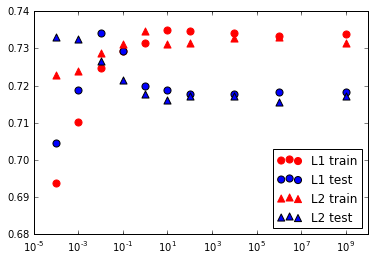

In [60]:
# add line, clean the code
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot()
labels = ['L1', 'L2']
markers = ['o','^']
ax.set_xscale('log')
ax.scatter(penalties, train_score[0,:], color='r',label = 'L1 train',marker=markers[0], s=50)
ax.scatter(penalties, test_score[0,:],label = 'L1 test', marker=markers[0], s=50)

ax.scatter(penalties, train_score[1,:], color='r',label = 'L2 train',marker=markers[1], s=50)
ax.scatter(penalties, test_score[1,:],label = 'L2 test', marker=markers[1], s=50)
ax.set_xscale('log')
plt.legend(loc=4) #, fontsize=25
plt.show()

In [61]:
# let's extract top 10 most important word for l2, week reguarlization
l1indices = np.argsort(-np.abs(coeff[0,0,:]))[:10]
l2indices = np.argsort(-np.abs(coeff[1,0,:]))[:10]
#print indices
l1coeff = coeff[0,:,l1indices]
l2coeff = coeff[1,:,l2indices]

In [62]:
l1words = weights_categories[l1indices].index
l2words = weights_categories[l2indices].index
print 'L1 regularization'
print l1words
print ''
print 'L2 regularization'
print l2words

L1 regularization
Index([u'C(occupation_husb)[T.3.0] C(occupation)[T.6.0]',
       u'C(occupation_husb)[T.2.0] C(occupation)[T.3.0]',
       u'C(occupation_husb)[T.5.0] C(occupation)[T.6.0]',
       u'C(occupation_husb)[T.2.0] C(occupation)[T.6.0]',
       u'C(occupation_husb)[T.2.0] C(occupation)[T.4.0]',
       u'C(occupation_husb)[T.2.0] C(occupation)[T.2.0]',
       u'C(occupation_husb)[T.5.0] C(occupation)[T.3.0]',
       u'C(occupation_husb)[T.6.0] C(occupation)[T.3.0]',
       u'C(occupation_husb)[T.6.0] C(occupation)[T.6.0]',
       u'C(occupation_husb)[T.2.0] C(occupation)[T.5.0]'],
      dtype='object')

L2 regularization
Index([u'Intercept rate_marriage', u'rate_marriage',
       u'C(occupation_husb)[T.4.0] C(occupation)[T.6.0]',
       u'C(occupation_husb)[T.3.0] C(occupation)[T.2.0]',
       u'Intercept C(occupation)[T.4.0]', u'C(occupation)[T.4.0]^2',
       u'C(occupation)[T.4.0]', u'Intercept children', u'children',
       u'Intercept C(occupation)[T.3.0]'],
      dtype

In [63]:
actual_pen = [1/i for i in penalties]

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 20

def make_coefficient_plot(l1coeff, l2coeff, l1_words, l2_words, penalty_list):
    cmap_l1 = plt.get_cmap('Reds')
    cmap_l2 = plt.get_cmap('Blues')
    
    xx = penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = l1coeff
    table_negative_words = l2coeff

    
    for i in xrange(len(l1_words)):
        color = cmap_l1(0.8*((i+1)/(len(l1_words)*1.2)+0.15))
        plt.plot(xx, l1coeff[i:i+1].flatten(),
                 '-', label=l1_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(l2_words)):
        color = cmap_l2(0.8*((i+1)/(len(l2_words)*1.2)+0.15))
        plt.plot(xx, (-1)*l2coeff[i:i+1].flatten(),
                 '-', label=l2_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc=1, ncol=2, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e4, -1, 2])
    plt.ylim([-0.2,0.2])
    plt.xlim([1, 1e4])
    plt.title('Coefficient path')
    plt.xlabel('Penalty')
    plt.ylabel('Coefficient value')
    plt.xscale('log')

    plt.rcParams.update({'font.size': 25})
    plt.tight_layout()

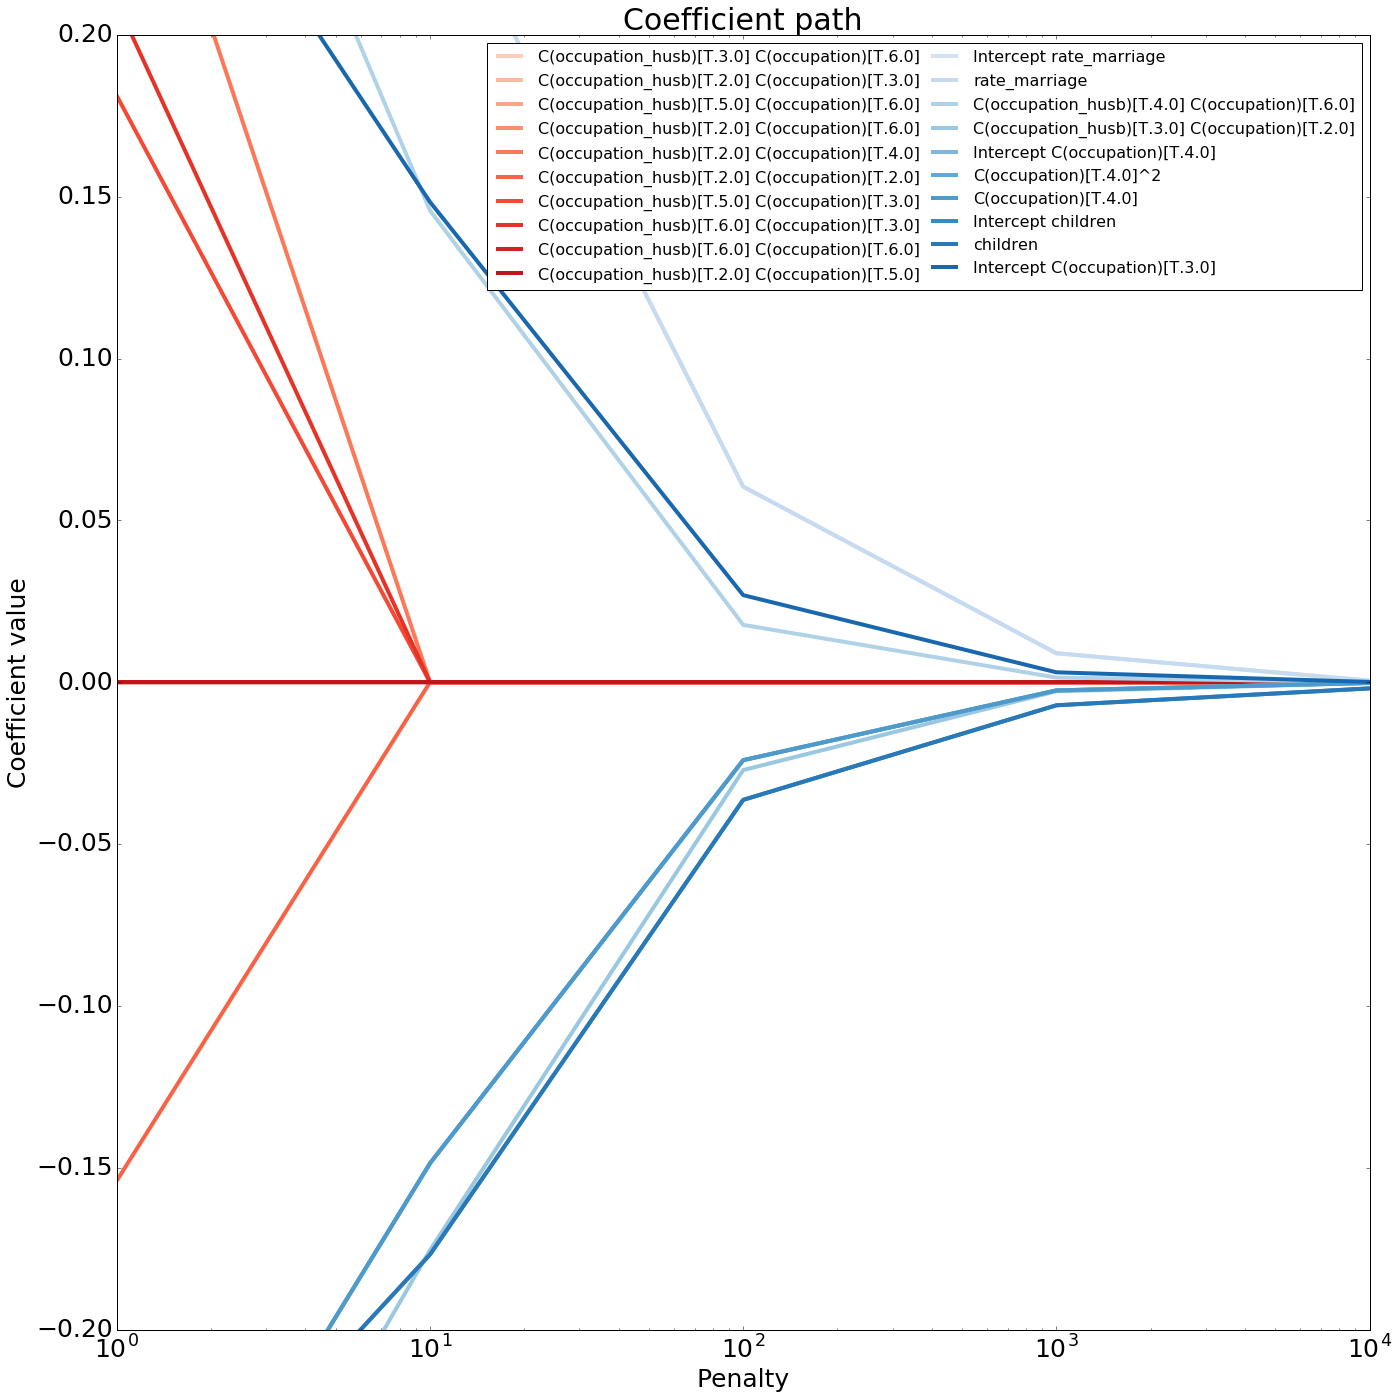

In [65]:
make_coefficient_plot(l1coeff, l2coeff, l1words, l2words, actual_pen)

### Caveat:
There are only ~6k data points in this dataset, so the difference in training/testing error could just be noise.

We will do better by doing cross-validation, but it's hard to gain much just because we don't have much data to start with.

##### Fin.